##Explore FrozenLakeEnv

In [0]:
import numpy as np
import copy
import check_test
from frozenlake import FrozenLakeEnv
from plot_utils import plot_values

In [0]:
env=FrozenLakeEnv()

In [0]:
print(env.observation_space)
print(env.action_space)

print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


In [0]:
env.P[1][3]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 0, 0.0, False)]

##Iterative Policy

In [0]:
def policy_evaluation(env,policy,gamma=1,theta=1e-8):
  V=np.zeros(env.nS)
  while True:
    delta=0
    for s in range(env.nS):
      Vs=0
      for a, action_prob in enumerate(policy[s]):
        for prob,next_state,reward,done in env.P[s][a]:
          Vs+=action_prob*prob*(reward+gamma*V[next_state])
      delta=max(delta,np.abs(V[s]-Vs))
      V[s]=Vs
    if delta<theta:
      break  
  return V

In [0]:
random_policy=np.ones([env.nS,env.nA])/env.nA

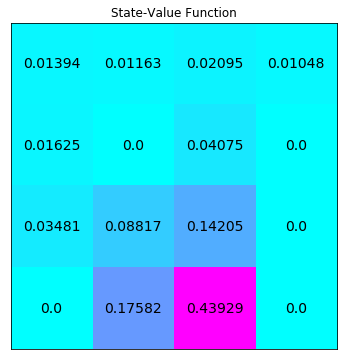

In [0]:
V=policy_evaluation(env,random_policy)
plot_values(V)

In [0]:
print(check_test.run_check('policy_evaluation_check', policy_evaluation))

**<span style="color: green;">PASSED</span>**

None


##Obtain q(pi) from v(pi)

In [0]:
def q_from_v(env,V,s,gamma=1):
  q=np.zeros(env.nA)
  for a in range(env.nA):
    for prob,next_state,reward,done in env.P[s][a]:
      q[a]+=prob*(reward+gamma*V[next_state])
  return q

In [0]:
Q=np.zeros([env.nS,env.nA])
for s in range(env.nS):
  Q[s]=q_from_v(env,V,s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [0]:
print(check_test.run_check('q_from_v_check', q_from_v))

**<span style="color: green;">PASSED</span>**

None


In [0]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        
        # OPTION 1: construct a deterministic policy 
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

In [0]:
check_test.run_check('policy_improvement_check', policy_improvement)

**<span style="color: green;">PASSED</span>**

##Policy Iteration

In [0]:
def policy_iteration(env,gamma=1,theta=1e-8):
  policy=np.ones([env.nS,env.nA])/env.nA
  while True:
    V=policy_evaluation(env,policy,gamma,theta)
    new_policy=policy_improvement(env,V)
    if(new_policy==policy).all():
      break;

    policy=copy.copy(new_policy)
  return policy,V


Optimal Policy (LEFT=0,Down=1,Right=2,Up=3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



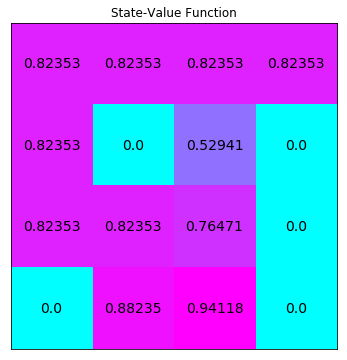

In [0]:
policy_pi,v_pi=policy_iteration(env)

print("\nOptimal Policy (LEFT=0,Down=1,Right=2,Up=3):")
print(policy_pi,"\n")

plot_values(v_pi)

In [0]:
check_test.run_check('policy_iteration_check', policy_iteration)

**<span style="color: green;">PASSED</span>**

##Truncated Policy Iteration

In [0]:
def truncated_policy_evaluation(env,policy,V,max_it=1,gamma=1):
  num_it=0
  while num_it<max_it:
    for s in range(env.nS):
      v=0
      q=q_from_v(env,V,s,gamma)
      for a,action_prob in enumerate(policy[s]):
        v+=action_prob*q[a]
      V[s]=v
      num_it+=1
  return V

In [0]:
def truncated_policy_iteration(env,max_it=1,gamma=1,theta=1e-8):
  V=np.zeros(env.nS)
  policy=np.zeros([env.nS,env.nA])/env.nA
  while True:
    policy=policy_improvement(env,V)
    old_V=copy.copy(V)
    V=truncated_policy_evaluation(env,policy,V,max_it,gamma)
    if max(abs(V-old_V))<theta:
      break;
  return policy,V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



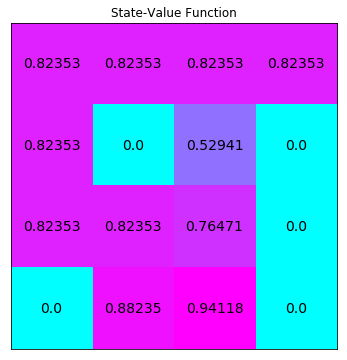

In [0]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

##Value Iteration

In [0]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



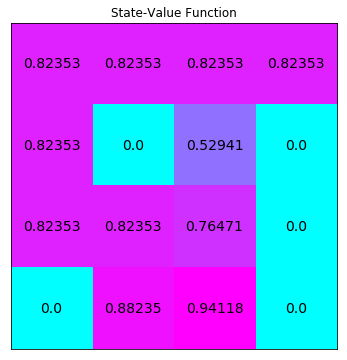

In [0]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)